<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

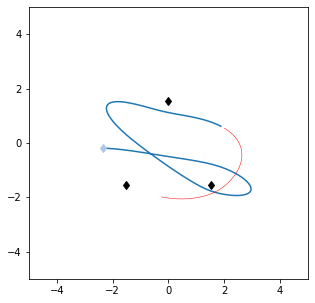

Charges are [-0.72358037 -0.91294927 -0.99138556]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [8]:
# Pick the best device
import torch

def try_device(device):
    # Try to put an array on given device. If successful, return device. Else, 'cpu'.
    x = torch.ones((1,))
    try:
        x.to(device)
        return device
    except:
        return 'cpu'

device = try_device('cuda')
if device == 'cpu':
    # mps doesn't support our model (yet?)
    # device = try_device('mps')
    pass


print(f'Device is set to {device}')

Device is set to cpu


In [9]:
# Task 3.1: Using the positions of positively charged particle p1 during a simulation, predict the
# values of negative charges c2, c3, c4
# input = t locations (x, y) of p1 particle, value of t is not fixed

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence

class SimulationData(Dataset):
    def __init__(self, sim, charges):
        self.sim = sim
        self.charges = charges

    def __len__(self):
        return len(self.sim)

    def __getitem__(self, idx):
        return self.sim[idx], self.charges[idx]

# Create data loader
def collate(data):
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    xs = pad_sequence([torch.tensor(x).float() for x, _ in data], batch_first=True)
    ys = torch.stack([torch.tensor(y).float() for _, y in data])
    return xs, ys

# Batch size needs to evenly divide all train, valid, test sizes (800, 100, 100)
batch_size = 5
train_dl = DataLoader(SimulationData(simulation_train, charges_train), batch_size=batch_size, shuffle=True, collate_fn=collate)
valid_dl = DataLoader(SimulationData(simulation_valid, charges_valid), batch_size=batch_size, shuffle=True, collate_fn=collate)


In [10]:
print(simulation_train[0].shape)
# Test data loader
xs, ys = next(iter(train_dl))
print(len(xs))
print(xs[0].shape, ys[0].shape)

(103, 2)
5
torch.Size([105, 2]) torch.Size([3])


In [11]:
# Baseline model: predict the mean value of each charge in the training set
baseline_values = torch.tensor(np.array(charges_train).mean(axis=0))
def baseline_predict(xs):
    batch = xs.shape[0]
    return baseline_values.expand(batch, 3)

loss_fn = lambda y, y_pred: (y - y_pred).abs().sum()

# Baseline error?

def avg_err(model, dl, loss_fn=torch.nn.L1Loss(reduction='sum')):
    with torch.no_grad():
        loss = 0
        n_samples = 0
        for x, y in dl:
            y_pred = model(x)
            loss += loss_fn(y, y_pred)
            n_samples += x.shape[0]
        return (loss / n_samples).item()


print(f'Baseline L1 train error: {avg_err(baseline_predict, train_dl)}')
print(f'Baseline L1 validation error: {avg_err(baseline_predict, valid_dl)}')

Baseline L1 train error: 0.742932140827179
Baseline L1 validation error: 0.7968491315841675


## Model Implementation

In [12]:
class Model_3_1(torch.nn.Module):
    def __init__(self, hidden_dim, n_layers, batch_size):
        super(Model_3_1, self).__init__()
        # input/output size are fixed based on the task description
        input_dim = 2
        output_dim = 3

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        self.gru = torch.nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = self.init_hidden()
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out
    
    def init_hidden(self):
        # from example of https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        h0 = torch.zeros(self.n_layers, self.batch_size, self.hidden_dim).to(device)
        return h0

xs = xs.to(device)
model_3_1 = Model_3_1(30, 5, batch_size).to(device)
print(model_3_1(xs).shape)

torch.Size([5, 3])


## Model Training

In [13]:
from tqdm import tqdm

def fit_3_1(model, train_dl, valid_dl, n_epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_func = torch.nn.L1Loss()
    train_history = []
    valid_history = []
    best_state_dict = model.state_dict().copy()

    for i in range(n_epochs):
        print(f'Begin epoch {i + 1}/{n_epochs}')
        model = model.train()
        for x, y in tqdm(train_dl):
            x = x.to(device=device)
            y = y.to(device=device)
            y_pred = model(x)
            loss = loss_func(y, y_pred)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model = model.eval()
        with torch.no_grad():
            train_err = avg_err(model, train_dl)
            print(f'L1 train error: {train_err}')
            val_err = avg_err(model, valid_dl)
            print(f'L1 validation error: {val_err}')
            train_history.append(train_err)
            valid_history.append(val_err)
            if val_err == min(valid_history):
                best_state_dict = model.state_dict().copy()

    return {
        'train': train_history,
        'valid': valid_history,
        'best_state': best_state_dict,
    }

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

hidden_size = 200
n_layers = 1
model_3_1 = Model_3_1(hidden_size, n_layers, batch_size).to(device)
print(f'Model has {count_parameters(model_3_1)} parameters')
epochs = 150
result = fit_3_1(model_3_1, train_dl, valid_dl, epochs)
print(f'Lowest validation error was {min(result["valid"])}')

Model has 123003 parameters
Begin epoch 1/150


100%|██████████| 160/160 [00:04<00:00, 38.42it/s]


L1 train error: 0.7281427979469299
L1 validation error: 0.7658876180648804
Begin epoch 2/150


100%|██████████| 160/160 [00:04<00:00, 36.70it/s]


L1 train error: 0.6270825862884521
L1 validation error: 0.6977683901786804
Begin epoch 3/150


100%|██████████| 160/160 [00:04<00:00, 38.49it/s]


L1 train error: 0.5406752228736877
L1 validation error: 0.5793208479881287
Begin epoch 4/150


100%|██████████| 160/160 [00:04<00:00, 37.82it/s]


L1 train error: 0.5210492610931396
L1 validation error: 0.5345797538757324
Begin epoch 5/150


100%|██████████| 160/160 [00:04<00:00, 35.88it/s]


L1 train error: 0.4278166890144348
L1 validation error: 0.44108331203460693
Begin epoch 6/150


100%|██████████| 160/160 [00:03<00:00, 40.08it/s]


L1 train error: 0.4246411919593811
L1 validation error: 0.42975398898124695
Begin epoch 7/150


100%|██████████| 160/160 [00:03<00:00, 40.54it/s]


L1 train error: 0.3507264256477356
L1 validation error: 0.3943341076374054
Begin epoch 8/150


100%|██████████| 160/160 [00:03<00:00, 40.22it/s]


L1 train error: 0.33649036288261414
L1 validation error: 0.37976861000061035
Begin epoch 9/150


100%|██████████| 160/160 [00:03<00:00, 40.64it/s]


L1 train error: 0.35261818766593933
L1 validation error: 0.3607662320137024
Begin epoch 10/150


100%|██████████| 160/160 [00:03<00:00, 40.35it/s]


L1 train error: 0.30349358916282654
L1 validation error: 0.3390556573867798
Begin epoch 11/150


100%|██████████| 160/160 [00:03<00:00, 40.66it/s]


L1 train error: 0.28118008375167847
L1 validation error: 0.3348350524902344
Begin epoch 12/150


100%|██████████| 160/160 [00:04<00:00, 39.75it/s]


L1 train error: 0.24318061769008636
L1 validation error: 0.27570298314094543
Begin epoch 13/150


100%|██████████| 160/160 [00:03<00:00, 40.62it/s]


L1 train error: 0.25212836265563965
L1 validation error: 0.27574294805526733
Begin epoch 14/150


100%|██████████| 160/160 [00:03<00:00, 40.55it/s]


L1 train error: 0.2311013787984848
L1 validation error: 0.24222955107688904
Begin epoch 15/150


100%|██████████| 160/160 [00:03<00:00, 40.57it/s]


L1 train error: 0.25356248021125793
L1 validation error: 0.2891134023666382
Begin epoch 16/150


100%|██████████| 160/160 [00:03<00:00, 40.50it/s]


L1 train error: 0.19914782047271729
L1 validation error: 0.22998414933681488
Begin epoch 17/150


100%|██████████| 160/160 [00:04<00:00, 39.82it/s]


L1 train error: 0.1923465132713318
L1 validation error: 0.22433069348335266
Begin epoch 18/150


100%|██████████| 160/160 [00:03<00:00, 40.73it/s]


L1 train error: 0.20098131895065308
L1 validation error: 0.25010251998901367
Begin epoch 19/150


100%|██████████| 160/160 [00:03<00:00, 40.36it/s]


L1 train error: 0.18813738226890564
L1 validation error: 0.22847427427768707
Begin epoch 20/150


100%|██████████| 160/160 [00:03<00:00, 40.24it/s]


L1 train error: 0.19058318436145782
L1 validation error: 0.2101396918296814
Begin epoch 21/150


100%|██████████| 160/160 [00:03<00:00, 40.40it/s]


L1 train error: 0.21454304456710815
L1 validation error: 0.2536240518093109
Begin epoch 22/150


100%|██████████| 160/160 [00:03<00:00, 40.48it/s]


L1 train error: 0.1789141595363617
L1 validation error: 0.20853981375694275
Begin epoch 23/150


100%|██████████| 160/160 [00:03<00:00, 40.52it/s]


L1 train error: 0.16943258047103882
L1 validation error: 0.19425971806049347
Begin epoch 24/150


100%|██████████| 160/160 [00:03<00:00, 40.69it/s]


L1 train error: 0.2112235575914383
L1 validation error: 0.22522835433483124
Begin epoch 25/150


100%|██████████| 160/160 [00:03<00:00, 40.25it/s]


L1 train error: 0.17742563784122467
L1 validation error: 0.20266267657279968
Begin epoch 26/150


100%|██████████| 160/160 [00:03<00:00, 40.35it/s]


L1 train error: 0.1792474240064621
L1 validation error: 0.2304902970790863
Begin epoch 27/150


100%|██████████| 160/160 [00:03<00:00, 40.49it/s]


L1 train error: 0.1567617952823639
L1 validation error: 0.18691933155059814
Begin epoch 28/150


100%|██████████| 160/160 [00:04<00:00, 39.25it/s]


L1 train error: 0.1677647978067398
L1 validation error: 0.21539634466171265
Begin epoch 29/150


100%|██████████| 160/160 [00:03<00:00, 40.53it/s]


L1 train error: 0.16248354315757751
L1 validation error: 0.19753682613372803
Begin epoch 30/150


100%|██████████| 160/160 [00:03<00:00, 40.62it/s]


L1 train error: 0.19305577874183655
L1 validation error: 0.2341729700565338
Begin epoch 31/150


100%|██████████| 160/160 [00:03<00:00, 40.55it/s]


L1 train error: 0.16251446306705475
L1 validation error: 0.18777140974998474
Begin epoch 32/150


100%|██████████| 160/160 [00:03<00:00, 40.51it/s]


L1 train error: 0.16600225865840912
L1 validation error: 0.20611386001110077
Begin epoch 33/150


100%|██████████| 160/160 [00:04<00:00, 39.59it/s]


L1 train error: 0.15957796573638916
L1 validation error: 0.17224912345409393
Begin epoch 34/150


100%|██████████| 160/160 [00:03<00:00, 40.45it/s]


L1 train error: 0.18252421915531158
L1 validation error: 0.21257391571998596
Begin epoch 35/150


100%|██████████| 160/160 [00:03<00:00, 40.13it/s]


L1 train error: 0.18437924981117249
L1 validation error: 0.20394077897071838
Begin epoch 36/150


100%|██████████| 160/160 [00:03<00:00, 40.60it/s]


L1 train error: 0.14930230379104614
L1 validation error: 0.1825069785118103
Begin epoch 37/150


100%|██████████| 160/160 [00:03<00:00, 40.52it/s]


L1 train error: 0.192295640707016
L1 validation error: 0.22217333316802979
Begin epoch 38/150


100%|██████████| 160/160 [00:03<00:00, 40.62it/s]


L1 train error: 0.18573489785194397
L1 validation error: 0.2073613554239273
Begin epoch 39/150


100%|██████████| 160/160 [00:04<00:00, 39.56it/s]


L1 train error: 0.16269928216934204
L1 validation error: 0.19036884605884552
Begin epoch 40/150


100%|██████████| 160/160 [00:03<00:00, 40.12it/s]


L1 train error: 0.15917156636714935
L1 validation error: 0.2122502326965332
Begin epoch 41/150


100%|██████████| 160/160 [00:03<00:00, 40.50it/s]


L1 train error: 0.1471461057662964
L1 validation error: 0.18470199406147003
Begin epoch 42/150


100%|██████████| 160/160 [00:03<00:00, 40.34it/s]


L1 train error: 0.1398993581533432
L1 validation error: 0.19071120023727417
Begin epoch 43/150


100%|██████████| 160/160 [00:03<00:00, 40.51it/s]


L1 train error: 0.15014509856700897
L1 validation error: 0.18888282775878906
Begin epoch 44/150


100%|██████████| 160/160 [00:04<00:00, 39.24it/s]


L1 train error: 0.16916798055171967
L1 validation error: 0.19426675140857697
Begin epoch 45/150


100%|██████████| 160/160 [00:03<00:00, 40.55it/s]


L1 train error: 0.1386783868074417
L1 validation error: 0.1617603898048401
Begin epoch 46/150


100%|██████████| 160/160 [00:03<00:00, 40.41it/s]


L1 train error: 0.14710602164268494
L1 validation error: 0.18591450154781342
Begin epoch 47/150


100%|██████████| 160/160 [00:03<00:00, 40.36it/s]


L1 train error: 0.12953656911849976
L1 validation error: 0.15446695685386658
Begin epoch 48/150


100%|██████████| 160/160 [00:03<00:00, 40.50it/s]


L1 train error: 0.13944949209690094
L1 validation error: 0.18224313855171204
Begin epoch 49/150


100%|██████████| 160/160 [00:03<00:00, 40.27it/s]


L1 train error: 0.20927968621253967
L1 validation error: 0.24016523361206055
Begin epoch 50/150


100%|██████████| 160/160 [00:04<00:00, 39.59it/s]


L1 train error: 0.12946230173110962
L1 validation error: 0.17089074850082397
Begin epoch 51/150


100%|██████████| 160/160 [00:03<00:00, 40.38it/s]


L1 train error: 0.12919311225414276
L1 validation error: 0.16511951386928558
Begin epoch 52/150


100%|██████████| 160/160 [00:03<00:00, 40.51it/s]


L1 train error: 0.13553644716739655
L1 validation error: 0.18684129416942596
Begin epoch 53/150


100%|██████████| 160/160 [00:03<00:00, 40.60it/s]


L1 train error: 0.1450875997543335
L1 validation error: 0.1855759471654892
Begin epoch 54/150


100%|██████████| 160/160 [00:04<00:00, 39.86it/s]


L1 train error: 0.11997301876544952
L1 validation error: 0.1653842180967331
Begin epoch 55/150


100%|██████████| 160/160 [00:04<00:00, 39.44it/s]


L1 train error: 0.14569082856178284
L1 validation error: 0.17697900533676147
Begin epoch 56/150


100%|██████████| 160/160 [00:03<00:00, 40.16it/s]


L1 train error: 0.12214650958776474
L1 validation error: 0.14718608558177948
Begin epoch 57/150


100%|██████████| 160/160 [00:03<00:00, 40.52it/s]


L1 train error: 0.1432531625032425
L1 validation error: 0.18153131008148193
Begin epoch 58/150


100%|██████████| 160/160 [00:03<00:00, 40.17it/s]


L1 train error: 0.18097691237926483
L1 validation error: 0.23285850882530212
Begin epoch 59/150


100%|██████████| 160/160 [00:03<00:00, 40.51it/s]


L1 train error: 0.12137075513601303
L1 validation error: 0.1684950590133667
Begin epoch 60/150


100%|██████████| 160/160 [00:03<00:00, 40.35it/s]


L1 train error: 0.13420040905475616
L1 validation error: 0.16329112648963928
Begin epoch 61/150


100%|██████████| 160/160 [00:03<00:00, 40.61it/s]


L1 train error: 0.11691409349441528
L1 validation error: 0.16544818878173828
Begin epoch 62/150


100%|██████████| 160/160 [00:03<00:00, 40.53it/s]


L1 train error: 0.12141235172748566
L1 validation error: 0.15861931443214417
Begin epoch 63/150


100%|██████████| 160/160 [00:03<00:00, 40.31it/s]


L1 train error: 0.15153969824314117
L1 validation error: 0.19120463728904724
Begin epoch 64/150


100%|██████████| 160/160 [00:03<00:00, 40.73it/s]


L1 train error: 0.14597177505493164
L1 validation error: 0.19324718415737152
Begin epoch 65/150


100%|██████████| 160/160 [00:03<00:00, 40.30it/s]


L1 train error: 0.13021965324878693
L1 validation error: 0.1613319218158722
Begin epoch 66/150


100%|██████████| 160/160 [00:04<00:00, 39.55it/s]


L1 train error: 0.13095316290855408
L1 validation error: 0.16113311052322388
Begin epoch 67/150


100%|██████████| 160/160 [00:03<00:00, 40.61it/s]


L1 train error: 0.1210816353559494
L1 validation error: 0.16112881898880005
Begin epoch 68/150


100%|██████████| 160/160 [00:03<00:00, 40.63it/s]


L1 train error: 0.14616598188877106
L1 validation error: 0.17109471559524536
Begin epoch 69/150


100%|██████████| 160/160 [00:04<00:00, 35.18it/s]


L1 train error: 0.13542115688323975
L1 validation error: 0.1750803142786026
Begin epoch 70/150


100%|██████████| 160/160 [00:04<00:00, 38.35it/s]


L1 train error: 0.12704376876354218
L1 validation error: 0.15955814719200134
Begin epoch 71/150


100%|██████████| 160/160 [00:03<00:00, 40.75it/s]


L1 train error: 0.1380903273820877
L1 validation error: 0.1691041886806488
Begin epoch 72/150


100%|██████████| 160/160 [00:03<00:00, 40.30it/s]


L1 train error: 0.1342015266418457
L1 validation error: 0.15189683437347412
Begin epoch 73/150


100%|██████████| 160/160 [00:03<00:00, 40.09it/s]


L1 train error: 0.11166748404502869
L1 validation error: 0.15531638264656067
Begin epoch 74/150


100%|██████████| 160/160 [00:03<00:00, 40.72it/s]


L1 train error: 0.11578448116779327
L1 validation error: 0.15340231359004974
Begin epoch 75/150


100%|██████████| 160/160 [00:03<00:00, 40.36it/s]


L1 train error: 0.12337596714496613
L1 validation error: 0.16118118166923523
Begin epoch 76/150


100%|██████████| 160/160 [00:04<00:00, 39.98it/s]


L1 train error: 0.1215829849243164
L1 validation error: 0.1550077497959137
Begin epoch 77/150


100%|██████████| 160/160 [00:03<00:00, 40.09it/s]


L1 train error: 0.11535021662712097
L1 validation error: 0.1568818986415863
Begin epoch 78/150


100%|██████████| 160/160 [00:03<00:00, 40.34it/s]


L1 train error: 0.12963813543319702
L1 validation error: 0.16690514981746674
Begin epoch 79/150


100%|██████████| 160/160 [00:03<00:00, 40.05it/s]


L1 train error: 0.11528915166854858
L1 validation error: 0.15120044350624084
Begin epoch 80/150


100%|██████████| 160/160 [00:03<00:00, 40.49it/s]


L1 train error: 0.12700463831424713
L1 validation error: 0.17185723781585693
Begin epoch 81/150


100%|██████████| 160/160 [00:03<00:00, 40.07it/s]


L1 train error: 0.11554805934429169
L1 validation error: 0.14982114732265472
Begin epoch 82/150


100%|██████████| 160/160 [00:03<00:00, 40.21it/s]


L1 train error: 0.12424691021442413
L1 validation error: 0.1600300669670105
Begin epoch 83/150


100%|██████████| 160/160 [00:03<00:00, 41.04it/s]


L1 train error: 0.11622258275747299
L1 validation error: 0.15833143889904022
Begin epoch 84/150


100%|██████████| 160/160 [00:03<00:00, 41.19it/s]


L1 train error: 0.12104684859514236
L1 validation error: 0.15547703206539154
Begin epoch 85/150


100%|██████████| 160/160 [00:04<00:00, 39.37it/s]


L1 train error: 0.12674707174301147
L1 validation error: 0.1851811558008194
Begin epoch 86/150


100%|██████████| 160/160 [00:03<00:00, 40.78it/s]


L1 train error: 0.13648195564746857
L1 validation error: 0.16824519634246826
Begin epoch 87/150


100%|██████████| 160/160 [00:03<00:00, 41.26it/s]


L1 train error: 0.11251896619796753
L1 validation error: 0.16115592420101166
Begin epoch 88/150


100%|██████████| 160/160 [00:03<00:00, 41.16it/s]


L1 train error: 0.10803429782390594
L1 validation error: 0.1526552140712738
Begin epoch 89/150


100%|██████████| 160/160 [00:03<00:00, 40.70it/s]


L1 train error: 0.10990434885025024
L1 validation error: 0.15895216166973114
Begin epoch 90/150


100%|██████████| 160/160 [00:03<00:00, 40.15it/s]


L1 train error: 0.11411509662866592
L1 validation error: 0.1535244584083557
Begin epoch 91/150


100%|██████████| 160/160 [00:04<00:00, 39.64it/s]


L1 train error: 0.11831330507993698
L1 validation error: 0.16516466438770294
Begin epoch 92/150


100%|██████████| 160/160 [00:03<00:00, 40.22it/s]


L1 train error: 0.18496334552764893
L1 validation error: 0.19755834341049194
Begin epoch 93/150


100%|██████████| 160/160 [00:04<00:00, 39.96it/s]


L1 train error: 0.11144384741783142
L1 validation error: 0.1485251486301422
Begin epoch 94/150


100%|██████████| 160/160 [00:03<00:00, 40.25it/s]


L1 train error: 0.10432819277048111
L1 validation error: 0.15098540484905243
Begin epoch 95/150


100%|██████████| 160/160 [00:03<00:00, 40.02it/s]


L1 train error: 0.13429008424282074
L1 validation error: 0.1726224720478058
Begin epoch 96/150


100%|██████████| 160/160 [00:04<00:00, 39.74it/s]


L1 train error: 0.1083296686410904
L1 validation error: 0.15273718535900116
Begin epoch 97/150


100%|██████████| 160/160 [00:03<00:00, 40.12it/s]


L1 train error: 0.14574579894542694
L1 validation error: 0.1821962147951126
Begin epoch 98/150


100%|██████████| 160/160 [00:03<00:00, 40.86it/s]


L1 train error: 0.12755757570266724
L1 validation error: 0.17859125137329102
Begin epoch 99/150


100%|██████████| 160/160 [00:03<00:00, 40.35it/s]


L1 train error: 0.1226905807852745
L1 validation error: 0.15889734029769897
Begin epoch 100/150


100%|██████████| 160/160 [00:03<00:00, 41.37it/s]


L1 train error: 0.1040586531162262
L1 validation error: 0.1544148176908493
Begin epoch 101/150


100%|██████████| 160/160 [00:03<00:00, 40.69it/s]


L1 train error: 0.11761634796857834
L1 validation error: 0.16558536887168884
Begin epoch 102/150


100%|██████████| 160/160 [00:03<00:00, 40.07it/s]


L1 train error: 0.12072587758302689
L1 validation error: 0.16323956847190857
Begin epoch 103/150


100%|██████████| 160/160 [00:03<00:00, 40.55it/s]


L1 train error: 0.12374012172222137
L1 validation error: 0.15861530601978302
Begin epoch 104/150


100%|██████████| 160/160 [00:03<00:00, 40.28it/s]


L1 train error: 0.11833067983388901
L1 validation error: 0.16705425083637238
Begin epoch 105/150


100%|██████████| 160/160 [00:03<00:00, 40.13it/s]


L1 train error: 0.11993131041526794
L1 validation error: 0.19096209108829498
Begin epoch 106/150


100%|██████████| 160/160 [00:03<00:00, 40.77it/s]


L1 train error: 0.10938314348459244
L1 validation error: 0.15318508446216583
Begin epoch 107/150


100%|██████████| 160/160 [00:03<00:00, 40.86it/s]


L1 train error: 0.0987921878695488
L1 validation error: 0.14718061685562134
Begin epoch 108/150


100%|██████████| 160/160 [00:03<00:00, 40.15it/s]


L1 train error: 0.10990315675735474
L1 validation error: 0.15102821588516235
Begin epoch 109/150


100%|██████████| 160/160 [00:03<00:00, 41.35it/s]


L1 train error: 0.11327295005321503
L1 validation error: 0.15406106412410736
Begin epoch 110/150


100%|██████████| 160/160 [00:03<00:00, 40.62it/s]


L1 train error: 0.1082393079996109
L1 validation error: 0.16205453872680664
Begin epoch 111/150


100%|██████████| 160/160 [00:04<00:00, 38.36it/s]


L1 train error: 0.1089366152882576
L1 validation error: 0.15887495875358582
Begin epoch 112/150


100%|██████████| 160/160 [00:03<00:00, 40.84it/s]


L1 train error: 0.12067178636789322
L1 validation error: 0.16133417189121246
Begin epoch 113/150


100%|██████████| 160/160 [00:03<00:00, 40.45it/s]


L1 train error: 0.12477435171604156
L1 validation error: 0.1412750631570816
Begin epoch 114/150


100%|██████████| 160/160 [00:03<00:00, 40.75it/s]


L1 train error: 0.11202702671289444
L1 validation error: 0.18674401938915253
Begin epoch 115/150


100%|██████████| 160/160 [00:03<00:00, 41.31it/s]


L1 train error: 0.12417837977409363
L1 validation error: 0.16475307941436768
Begin epoch 116/150


100%|██████████| 160/160 [00:03<00:00, 41.06it/s]


L1 train error: 0.10989754647016525
L1 validation error: 0.15828892588615417
Begin epoch 117/150


100%|██████████| 160/160 [00:03<00:00, 41.26it/s]


L1 train error: 0.12790608406066895
L1 validation error: 0.17356765270233154
Begin epoch 118/150


100%|██████████| 160/160 [00:03<00:00, 40.70it/s]


L1 train error: 0.11159558594226837
L1 validation error: 0.14301139116287231
Begin epoch 119/150


100%|██████████| 160/160 [00:03<00:00, 40.46it/s]


L1 train error: 0.10295591503381729
L1 validation error: 0.15084834396839142
Begin epoch 120/150


100%|██████████| 160/160 [00:03<00:00, 40.33it/s]


L1 train error: 0.10732869058847427
L1 validation error: 0.15634708106517792
Begin epoch 121/150


100%|██████████| 160/160 [00:03<00:00, 40.55it/s]


L1 train error: 0.08901902288198471
L1 validation error: 0.14980947971343994
Begin epoch 122/150


100%|██████████| 160/160 [00:03<00:00, 40.57it/s]


L1 train error: 0.11051144450902939
L1 validation error: 0.14956432580947876
Begin epoch 123/150


100%|██████████| 160/160 [00:03<00:00, 40.55it/s]


L1 train error: 0.10455465316772461
L1 validation error: 0.15590693056583405
Begin epoch 124/150


100%|██████████| 160/160 [00:04<00:00, 39.48it/s]


L1 train error: 0.1213247999548912
L1 validation error: 0.1678021401166916
Begin epoch 125/150


100%|██████████| 160/160 [00:03<00:00, 40.51it/s]


L1 train error: 0.10409529507160187
L1 validation error: 0.13361072540283203
Begin epoch 126/150


100%|██████████| 160/160 [00:04<00:00, 35.77it/s]


L1 train error: 0.09885341674089432
L1 validation error: 0.14476372301578522
Begin epoch 127/150


100%|██████████| 160/160 [00:04<00:00, 33.83it/s]


L1 train error: 0.11061917990446091
L1 validation error: 0.17087671160697937
Begin epoch 128/150


100%|██████████| 160/160 [00:04<00:00, 34.92it/s]


L1 train error: 0.11534654349088669
L1 validation error: 0.15208134055137634
Begin epoch 129/150


100%|██████████| 160/160 [00:06<00:00, 24.98it/s]


L1 train error: 0.10556559264659882
L1 validation error: 0.15492673218250275
Begin epoch 130/150


100%|██████████| 160/160 [00:03<00:00, 40.54it/s]


L1 train error: 0.09675223380327225
L1 validation error: 0.15036965906620026
Begin epoch 131/150


100%|██████████| 160/160 [00:03<00:00, 40.40it/s]


L1 train error: 0.09274716675281525
L1 validation error: 0.14108195900917053
Begin epoch 132/150


100%|██████████| 160/160 [00:03<00:00, 40.74it/s]


L1 train error: 0.10432982444763184
L1 validation error: 0.15064619481563568
Begin epoch 133/150


100%|██████████| 160/160 [00:04<00:00, 39.21it/s]


L1 train error: 0.11541241407394409
L1 validation error: 0.1623935103416443
Begin epoch 134/150


100%|██████████| 160/160 [00:03<00:00, 40.56it/s]


L1 train error: 0.08681938797235489
L1 validation error: 0.14813855290412903
Begin epoch 135/150


100%|██████████| 160/160 [00:03<00:00, 41.21it/s]


L1 train error: 0.09951308369636536
L1 validation error: 0.1446540802717209
Begin epoch 136/150


100%|██████████| 160/160 [00:03<00:00, 40.31it/s]


L1 train error: 0.10134798288345337
L1 validation error: 0.1810779571533203
Begin epoch 137/150


100%|██████████| 160/160 [00:03<00:00, 40.75it/s]


L1 train error: 0.10891582816839218
L1 validation error: 0.14931648969650269
Begin epoch 138/150


100%|██████████| 160/160 [00:03<00:00, 40.45it/s]


L1 train error: 0.10874290764331818
L1 validation error: 0.16139984130859375
Begin epoch 139/150


100%|██████████| 160/160 [00:03<00:00, 40.98it/s]


L1 train error: 0.08840565383434296
L1 validation error: 0.13892856240272522
Begin epoch 140/150


100%|██████████| 160/160 [00:03<00:00, 41.07it/s]


L1 train error: 0.10513192415237427
L1 validation error: 0.1615111231803894
Begin epoch 141/150


100%|██████████| 160/160 [00:03<00:00, 40.64it/s]


L1 train error: 0.09083492308855057
L1 validation error: 0.1425183266401291
Begin epoch 142/150


100%|██████████| 160/160 [00:04<00:00, 39.84it/s]


L1 train error: 0.10774455964565277
L1 validation error: 0.15389485657215118
Begin epoch 143/150


100%|██████████| 160/160 [00:03<00:00, 40.38it/s]


L1 train error: 0.09313531219959259
L1 validation error: 0.13744419813156128
Begin epoch 144/150


100%|██████████| 160/160 [00:03<00:00, 41.03it/s]


L1 train error: 0.09943445026874542
L1 validation error: 0.14920538663864136
Begin epoch 145/150


100%|██████████| 160/160 [00:03<00:00, 40.70it/s]


L1 train error: 0.09174149483442307
L1 validation error: 0.15211175382137299
Begin epoch 146/150


100%|██████████| 160/160 [00:04<00:00, 39.89it/s]


L1 train error: 0.08931419253349304
L1 validation error: 0.1532866358757019
Begin epoch 147/150


100%|██████████| 160/160 [00:03<00:00, 40.95it/s]


L1 train error: 0.10129701346158981
L1 validation error: 0.15414118766784668
Begin epoch 148/150


100%|██████████| 160/160 [00:03<00:00, 41.53it/s]


L1 train error: 0.09940458089113235
L1 validation error: 0.1467984914779663
Begin epoch 149/150


100%|██████████| 160/160 [00:03<00:00, 40.72it/s]


L1 train error: 0.10106293857097626
L1 validation error: 0.151459202170372
Begin epoch 150/150


100%|██████████| 160/160 [00:03<00:00, 41.21it/s]


L1 train error: 0.10714664310216904
L1 validation error: 0.15410250425338745
Lowest validation error was 0.13361072540283203


## Evaluation

Test L1 error is 0.13292494416236877


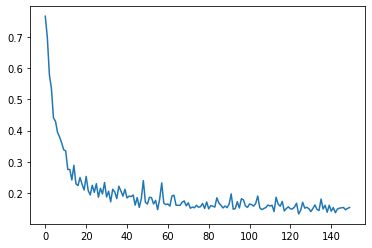

In [36]:
test_dl = DataLoader(SimulationData(simulation_test, charges_test), batch_size=batch_size, shuffle=True, collate_fn=collate)
model_3_1 = model_3_1.eval()
print(f'Test L1 error is {avg_err(model_3_1, test_dl)}')


plt.plot(result['valid'])

# Task 3.2

## Data Handling and Preprocessing

In [16]:
#todo

## Model Implementation

In [17]:
#todo

## Model Training

In [18]:
#todo

## Evaluation

In [19]:
#todo